# Исследование сервиса аренды самокатов GoFast

Для популярного сервиса аренды самокатов GoFast необходимо проанализировать данные о некоторых пользователях из нескольких городов и их поездках и проверить гипотезы, которые могут помочь бизнесу вырасти. 
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.  
Сервисом можно пользоваться:  

без подписки  
абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;  
стоимость старта (начала поездки) — 50 рублей;    

с подпиской Ultra  
абонентская плата — 199 рублей в месяц;  
стоимость одной минуты поездки — 6 рублей;  
стоимость старта — бесплатно.

В ходе анализа проведём:
- предобработку данных: проверим датафреймы на наличие пропусков и дубликатов, приведём столбцы к необходимым форматам,а также создадим новый столбец; 
- исследовательский анализ: приведём описание и визуализацию общей информации о пользователях и поездках, рассмотрим такие характеристики, как частота встречаемости городов, соотношение пользователей с подпиской и без подписки, возраст пользователей, расстояние, которое пользователь преодолел за одну поездку, продолжительность поездок;
- объединение данных: объединим данные о пользователях, поездках и подписках в один датафрейм, на основе которого создадим ещё два дополнительных датафрейма (с данными о пользователях без подписки и с данными о пользователях с подпиской), а также визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий;
- подсчёт выручки: создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из предыдущего шага и найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, в полученный датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь;
- проверку гипотез: проверить какие акции приведут к увеличению количества пользователей с подпиской.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd

import seaborn as sns

from scipy import stats as st
from scipy.stats import binom
from scipy.stats import binomtest

import numpy as np

import matplotlib.pyplot as plt

from math import factorial
from math import sqrt

# настроим среду
sns.set(rc={'figure.figsize':(15,5)})
pd.set_option('display.max_columns', None)

## Изучение данных

In [2]:
users = pd.read_csv('C:/Users/drweb/datasets/users_go.csv')
rides = pd.read_csv('C:/Users/drweb/datasets/rides_go.csv')
subscriptions = pd.read_csv('C:/Users/drweb/datasets/subscriptions_go.csv')

Выведем основную информацию и первые строки датафреймов.

In [3]:
users.info()
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
rides.info()
rides.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [5]:
subscriptions.info()
subscriptions.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В датафрейме users представлено 1565 строк и 5 столбцов(user_id, age с целочисленным типом данных; name, city, subscription_type с типом данных object).\
В rides - 18068 строк и 4 столбца(user_id с целочисленным типом данных; distance и duration с вещественными числами; date с типом данных object).\
В subscriptions - 2 строки и 4 столбца(subscription_type с типом данных object; minute_price, start_ride_price, subscription_fee с целочисленным типом данных. 

#### Шаг 2. Предобработка данных

Сменим формат данных в столбце date датафрейма rides на дату; создадим новый столбец с указанием месяца поездок.

In [6]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['ride_month'] = rides['date'].dt.month

В датафрейме users представлено 1565 строк и 5 столбцов(user_id, age с целочисленным типом данных; name, city, subscription_type с типом данных object).\
В rides - 18068 строк и 4 столбца(user_id с целочисленным типом данных; distance и duration с вещественными числами; date с типом данных object).\
В subscriptions - 2 строки и 4 столбца(subscription_type с типом данных object; minute_price, start_ride_price, subscription_fee с целочисленным типом данных. 

## Предобработка данных

Сменим формат данных в столбце date датафрейма rides на дату; создадим новый столбец с указанием месяца поездок.

In [7]:
print('Минимальная дата :', rides['date'].min())
print('Максимальная дата:', rides['date'].max())

Минимальная дата : 2021-01-01 00:00:00
Максимальная дата: 2021-12-30 00:00:00


Данные представлены за 1 год.

### Обработка пропусков и дубликатов 

Проверим наличие дубликатов и пропусков в датафреймах

In [8]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [9]:
rides.isna().sum()

user_id       0
distance      0
duration      0
date          0
ride_month    0
dtype: int64

In [10]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропуски в данных отсутствуют

In [11]:
users[users.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [12]:
users.duplicated().sum()

31

Удалим дубликаты

In [13]:
users.drop_duplicates().reset_index(drop=True, inplace=True)

In [14]:
users.duplicated().sum()

31

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [16]:
rides.duplicated().sum()

0

In [17]:
subscriptions.duplicated().sum()

0

**Вывод:**  
<span style="color:green"> В ходе предобработки данных мы удостоверились, что пропуски и дубликаты в данных отсутствуют.</span>

## Исследовательский анализ данных

Посмотрим на описание данных.

### Датафрейм users

In [18]:
users.describe(include='all', percentiles=[0.01, 0.05,0.25,0.5,0.75, 0.95, 0.99])

,user_id,name,age,city,subscription_type
count,1565.000000,1565,1565.000000,1565,1565
unique,NaN,194,NaN,8,2
top,NaN,Мария,NaN,Пятигорск,free
freq,NaN,23,NaN,226,846
mean,762.633866,NaN,24.922045,NaN,NaN
std,443.260155,NaN,4.553496,NaN,NaN
min,1.000000,NaN,12.000000,NaN,NaN
1%,16.000000,NaN,14.000000,NaN,NaN
5%,75.200000,NaN,17.200000,NaN,NaN
25%,378.000000,NaN,22.000000,NaN,NaN


На первый взгляд описание данных в порядке. На всякий случай проверим данные с помощью графика с усами.

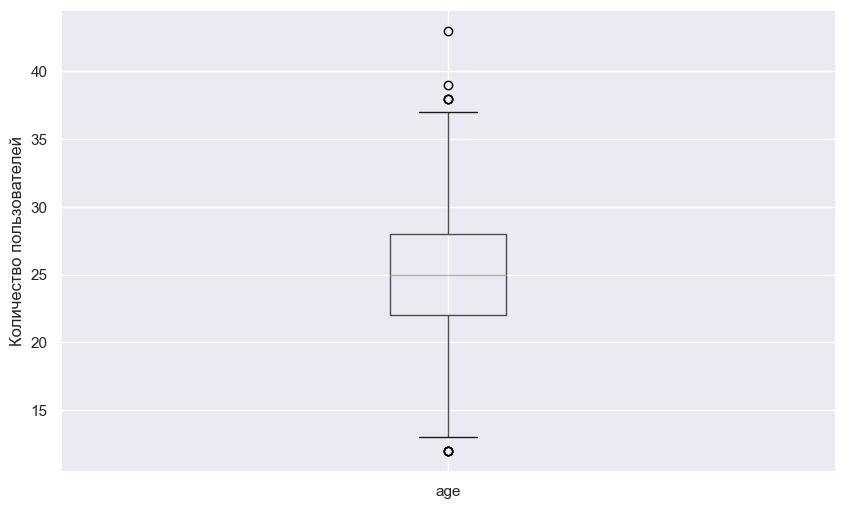

In [19]:
def boxplot(df, x):
    df.boxplot(column=x, grid=True, figsize=(10,6))
    plt.ylabel('Количество пользователей')
    plt.show()
    
boxplot(users, 'age')

Данные в порядке, необъяснимые аномалии отсутствуют.

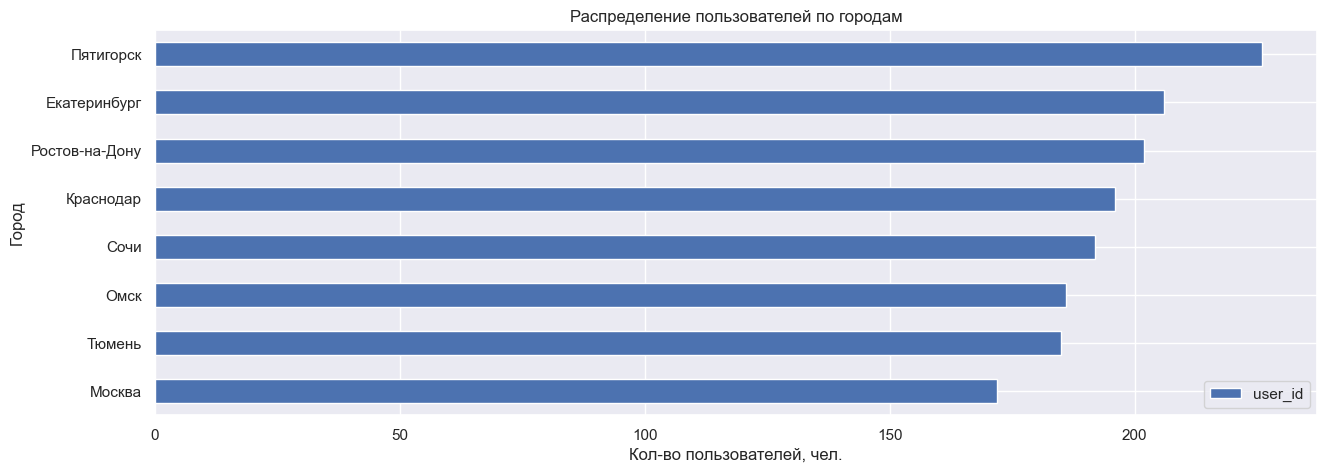

In [20]:
users_pivot = users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id')
users_pivot.plot(kind='barh', grid='True')
plt.title('Распределение пользователей по городам')
plt.ylabel('Город')
plt.xlabel('Кол-во пользователей, чел.')
plt.show()

In [21]:
users_pivot

,user_id
city,
Москва,172
Тюмень,185
Омск,186
Сочи,192
Краснодар,196
Ростов-на-Дону,202
Екатеринбург,206
Пятигорск,226


Отметим, что сервис аренды самокатов представлен на юге европейской части России, в Западной Сибири и в столице. 
Наиболее популярен в Пятигорске, наименее - в Москве.

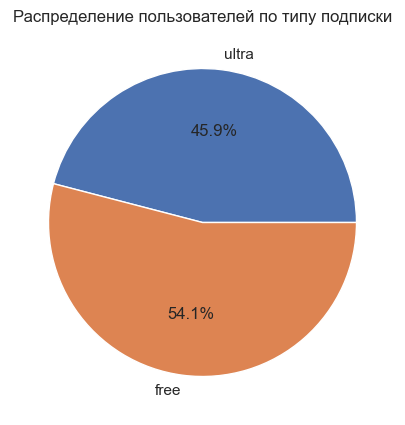

In [22]:
users_subs_pivot = users.pivot_table(index='subscription_type', values='user_id', aggfunc='count').sort_values(by='user_id')

fig, ax = plt.subplots()
labels = 'ultra', 'free'
ax.pie(users_subs_pivot['user_id'], labels = labels, autopct='%1.1f%%')
plt.title('Распределение пользователей по типу подписки')
plt.show()

In [23]:
users_subs_pivot['ratio'] = (users_subs_pivot['user_id']/1534).round(2)
users_subs_pivot

,user_id,ratio
subscription_type,,
ultra,719,0.47
free,846,0.55


Количество пользователей с разными видами подписки не сильно отличается, при этом превуалируют пользователи с бесплатной подпиской (около 54%)

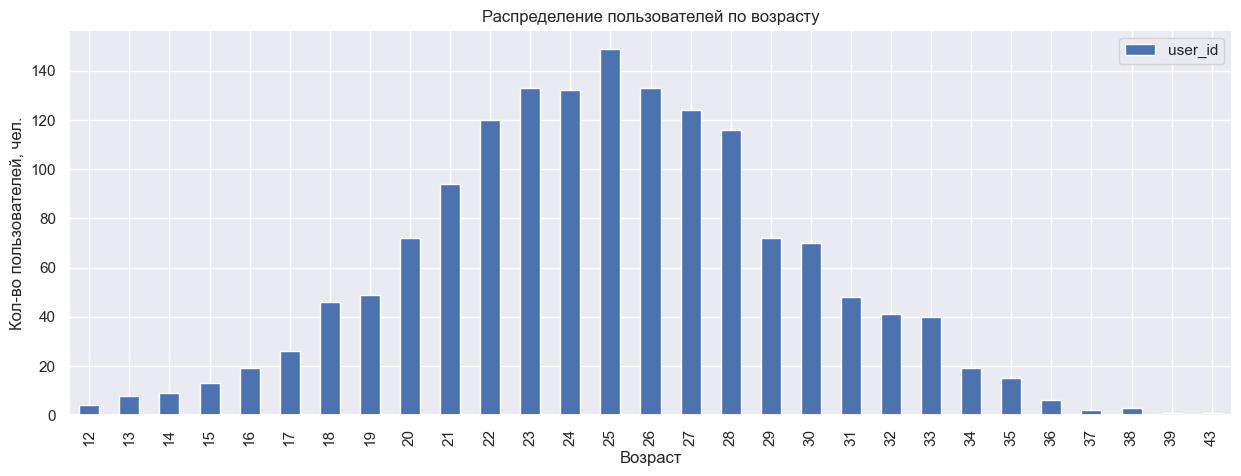

In [24]:
users_age_pivot = users.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age')
users_age_pivot.plot(kind='bar', grid='True')
plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Кол-во пользователей, чел.')
plt.show()

In [25]:
users_age_pivot

,user_id
age,
12,4
13,8
14,9
15,13
16,19
17,26
18,46
19,49
20,72


Отметим, что график показывает нормальное распределение совокупности. Наиболее часто сервисом пользуются молодые люди со средним возрастом около 25 лет. Чем дальше от среднего в любую сторону, тем меньше пользователей становится.

### Датафрейм rides

In [26]:
rides.describe(include='all', percentiles=[0.01, 0.05,0.25,0.5,0.75, 0.95, 0.99])

,user_id,distance,duration,date,ride_month
count,18068.000000,18068.000000,18068.000000,18068,18068.000000
mean,842.869936,3070.659976,17.805011,2021-06-30 19:47:21.266327296,6.486772
min,1.000000,0.855683,0.500000,2021-01-01 00:00:00,1.000000
1%,18.000000,208.084405,3.982105,2021-01-04 00:00:00,1.000000
5%,96.000000,689.007279,8.244528,2021-01-18 00:00:00,1.000000
25%,487.000000,2543.226360,13.597563,2021-04-02 00:00:00,4.000000
50%,889.000000,3133.609994,17.678395,2021-06-30 00:00:00,6.000000
75%,1213.250000,3776.222735,21.724800,2021-09-28 00:00:00,9.000000
95%,1471.000000,4740.088596,28.428730,2021-12-13 00:00:00,12.000000
99%,1523.000000,5478.621528,32.503580,2021-12-27 00:00:00,12.000000


Проверим данные с помощью графиков с усами

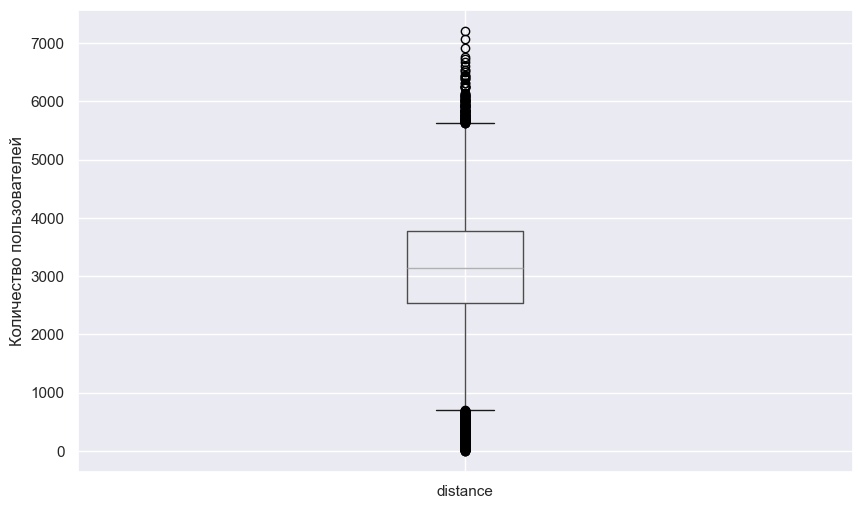

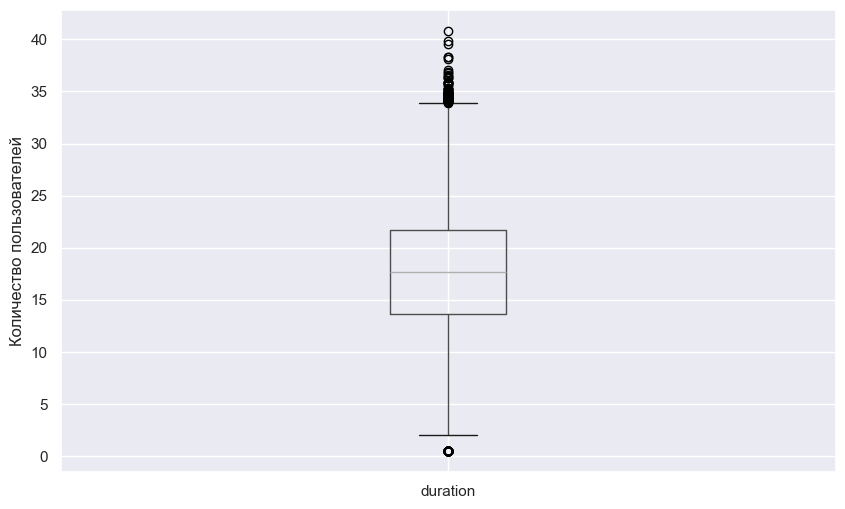

In [27]:
boxplot(rides, 'distance')
boxplot(rides, 'duration')

Необъяснимых выбросов нет

Построим график для визуализации расстояния, преодолеваемого пользователями за одну поездку. Для этого осуществим категоризацию данных

In [28]:
def categorize_distance(distance):
    try:
        if 0 <= distance <= 1000:
            return '0-1 км.'
        elif 1000.01 <= distance <= 2000:
            return '1-2 км.'
        elif 2000.01 <= distance <= 3000:
            return '2-3 км.'
        elif 3000.01 <= distance <=4000:
            return '3-4 км.'
        elif 4000.01 <= distance <=5000:
            return '4-5 км.'
        elif 5000.01 <= distance <=6000:
            return '5-6 км.'
        elif distance >= 6000.1:
            return 'свыше 6 км.'
    except:
        pass
    
rides['distance_category'] = rides['distance'].apply(categorize_distance)

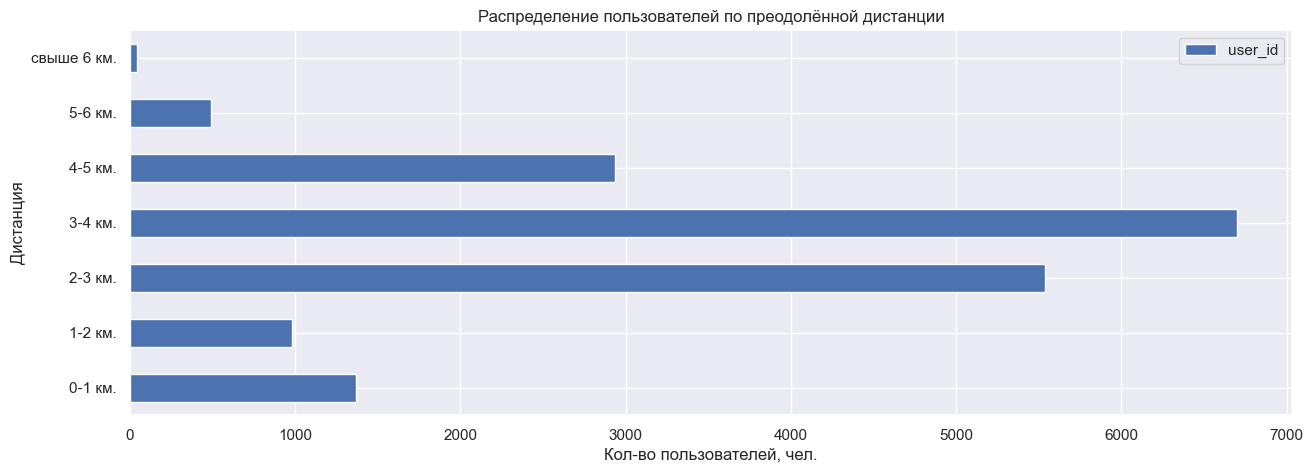

In [29]:
rides_dist_pivot = rides.pivot_table(index='distance_category', values='user_id', aggfunc='count')
rides_dist_pivot.plot(kind='barh', grid='True')
plt.title('Распределение пользователей по преодолённой дистанции')
plt.ylabel('Дистанция')
plt.xlabel('Кол-во пользователей, чел.')
plt.show()

In [30]:
rides_dist_pivot['ratio'] = (rides_dist_pivot['user_id']/(rides['user_id'].count())).round(2)
rides_dist_pivot

,user_id,ratio
distance_category,,
0-1 км.,1372,0.08
1-2 км.,980,0.05
2-3 км.,5540,0.31
3-4 км.,6698,0.37
4-5 км.,2937,0.16
5-6 км.,495,0.03
свыше 6 км.,46,0.00


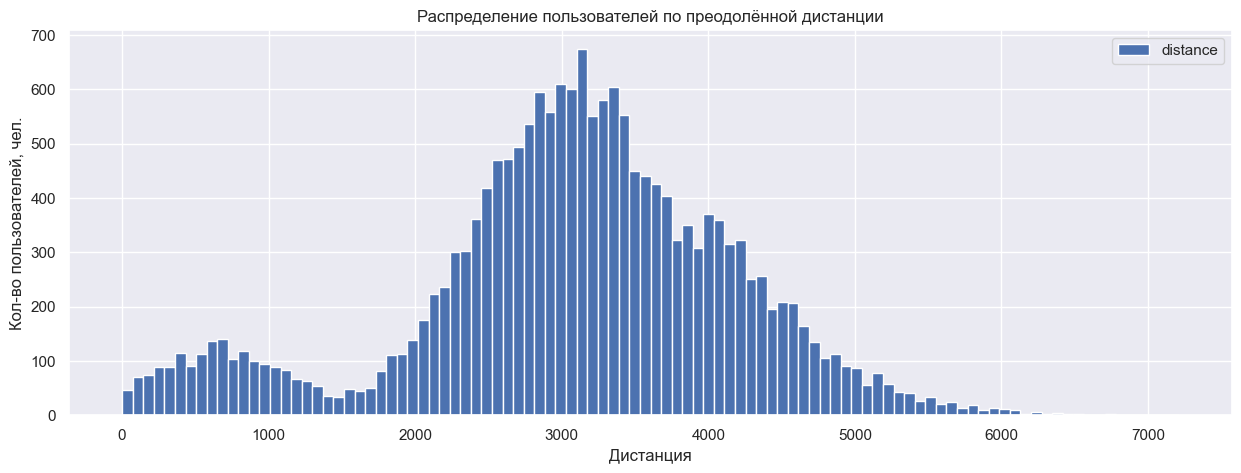

In [31]:
rides.plot(kind='hist', y='distance', x='user_id', bins=100)
plt.title('Распределение пользователей по преодолённой дистанции')
plt.xlabel('Дистанция')
plt.ylabel('Кол-во пользователей, чел.')
plt.show()

    Наиболее часто пользователи проезжают расстояние от 3 до 4 км, наименее часто - свыше 6 км. 84% пользователей проезжают расстояние от 2 до 5 км.
    За одну поездку пользователи преодолевают от 1 до 7211 метров. Медиана равна 3134 метров. Наблюдаются два пика. 
    Малый пик около 700 метров, большой пик около 3200 метров. Между пиками значения нормально распределены.

Построим график для визуализации продолжительности поездок. Категоризуем время поездок по группам

In [32]:
def categorize_duration(duration):
    try:
        if 0 <= duration <= 10:
            return '0-10 мин.'
        elif 10.0001 <= duration <= 20:
            return '10-20 мин.'
        elif 20.0001 <= duration <= 30:
            return '20-30 мин.'
        elif duration >= 30.0001:
            return 'свыше 30 мин.'
    except:
        pass
    
rides['duration_category'] = rides['duration'].apply(categorize_duration)

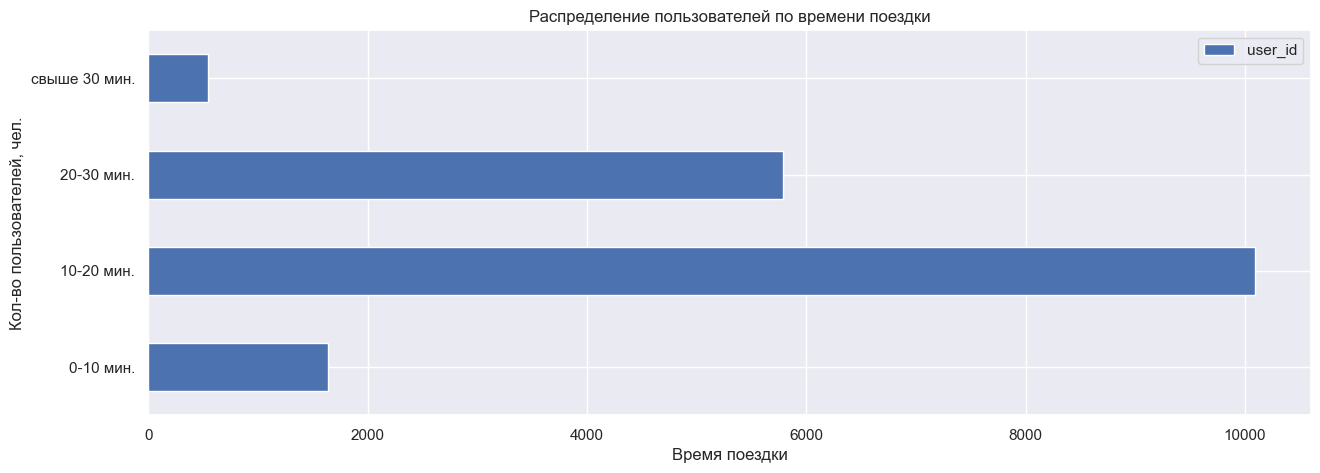

In [33]:
rides_dur_pivot = rides.pivot_table(index='duration_category', values='user_id', aggfunc='count')\
.sort_values(by='duration_category')
rides_dur_pivot.plot(kind='barh', grid='True')
plt.title('Распределение пользователей по времени поездки')
plt.xlabel('Время поездки')
plt.ylabel('Кол-во пользователей, чел.')
plt.show()

In [34]:
rides_dur_pivot['ratio'] = (rides_dur_pivot['user_id']/(rides['user_id'].count())).round(2)
rides_dur_pivot

,user_id,ratio
duration_category,,
0-10 мин.,1639,0.09
10-20 мин.,10095,0.56
20-30 мин.,5791,0.32
свыше 30 мин.,543,0.03


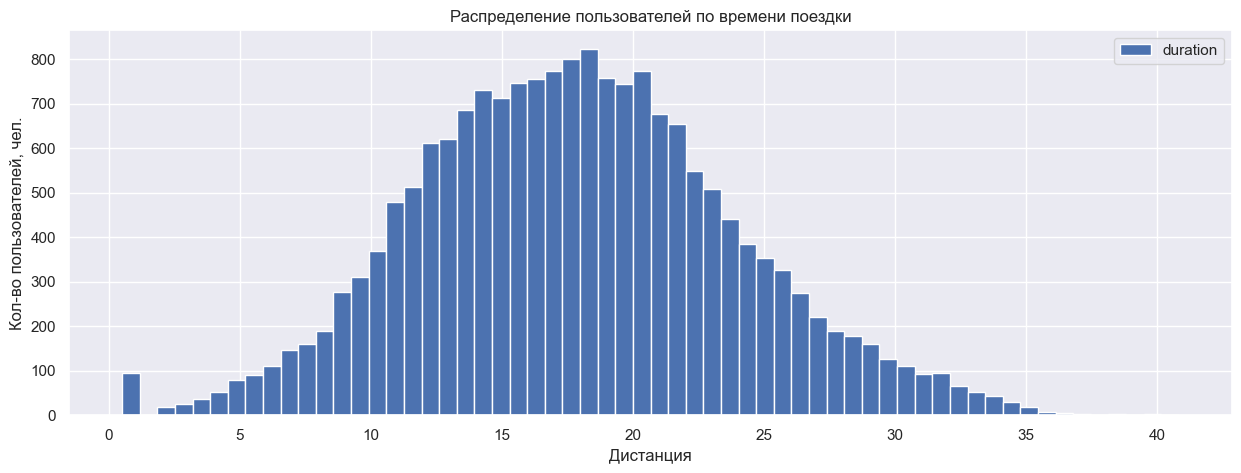

In [35]:
rides.plot(kind='hist', y='duration', x='user_id', bins=60)
plt.title('Распределение пользователей по времени поездки')
plt.xlabel('Дистанция')
plt.ylabel('Кол-во пользователей, чел.')
plt.show()

    В основном, а именно в 56% случаев пользователи проезжают от 10 до 20 минут. Меньше всего времени пользователи тратят на поездки от 30 минут. Присутствует необычный выброс количества поездок (около 100) длительность до 1 минуты. Такое может происходить из-за технических неисправностей, связанных с началом поездки, в результате чего пользователи останавливают поездку.
    Длительность поездок нормально распределена в промежутке от 0 до 41 минуты. Мединное время поездки - около 18 минут.

### Датафрейм subscriptions

In [36]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


In [37]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


    В датафрейме всего 2 строчки. Какие-либо странности в нём отсутствуют

**Вывод:**  

<span style="color:green">1) Услугами сервиса аренды самокатов пользуются люди от 12 до 43 лет.\
2) Максимальное количество пользователей в возрасте 25 лет, этот же возраст является медианным.\
3) Большая часть всех пользователей используют подписку "free". Всего их 835, что составляет около 54% от общего количества и на 136 больше, чем с подпиской "ultra".\
4) Максимальное количество в 219 поездок совершено в Пятигорске. Минимальное количество в 168 поездок совершено в Москве.\
5) За одну поездку пользователи преодолевают расстояние от 1 до 7211 метров. Медиана пройденной дистанции равна 3134 метров. Наблюдаются два пика. Малый пик около 700 метров, большой пик около 3200 метров. Между пиками значения нормально распределены.\
6) Продолжительность поездок нормально распределена от 0 до 41 минуты. Продолжительность в 18 минут является наиболее распространенной, а также медианой. Наблюдается выброс размером около 100 поездок с продолжительностью в 1 минуту.</span>

## Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [38]:
df = users.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18388 entries, 0 to 18387
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18388 non-null  int64         
 1   name               18388 non-null  object        
 2   age                18388 non-null  int64         
 3   city               18388 non-null  object        
 4   subscription_type  18388 non-null  object        
 5   distance           18388 non-null  float64       
 6   duration           18388 non-null  float64       
 7   date               18388 non-null  datetime64[ns]
 8   ride_month         18388 non-null  int32         
 9   distance_category  18388 non-null  object        
 10  duration_category  18388 non-null  object        
 11  minute_price       18388 non-null  int64         
 12  start_ride_price   18388 non-null  int64         
 13  subscription_fee   18388 non-null  int64         
dtypes: dat

In [40]:
df.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,distance_category,duration_category,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,4-5 км.,20-30 мин.,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2-3 км.,10-20 мин.,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,0-1 км.,0-10 мин.,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2-3 км.,10-20 мин.,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,4-5 км.,20-30 мин.,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,2-3 км.,10-20 мин.,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,3-4 км.,10-20 мин.,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,2-3 км.,20-30 мин.,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,3-4 км.,10-20 мин.,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,0-1 км.,10-20 мин.,6,0,199


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18388 entries, 0 to 18387
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18388 non-null  int64         
 1   name               18388 non-null  object        
 2   age                18388 non-null  int64         
 3   city               18388 non-null  object        
 4   subscription_type  18388 non-null  object        
 5   distance           18388 non-null  float64       
 6   duration           18388 non-null  float64       
 7   date               18388 non-null  datetime64[ns]
 8   ride_month         18388 non-null  int32         
 9   distance_category  18388 non-null  object        
 10  duration_category  18388 non-null  object        
 11  minute_price       18388 non-null  int64         
 12  start_ride_price   18388 non-null  int64         
 13  subscription_fee   18388 non-null  int64         
dtypes: dat

In [42]:
print(f"Количество уникальных идентификаторов в датафрейме users: {users['user_id'].nunique()}")
print(f"Количество уникальных идентификаторов в датафрейме df: {df['user_id'].nunique()}")
print()
print(f"Количество строк в датафрейме rides: {rides['user_id'].count()}")
print(f"Количество строк в датафрейме df: {df['user_id'].count()}")

Количество уникальных идентификаторов в датафрейме users: 1534
Количество уникальных идентификаторов в датафрейме df: 1534

Количество строк в датафрейме rides: 18068
Количество строк в датафрейме df: 18388


Потери или появления лишних данных не произошло. Пропуски отсутствуют

Создадим ещё два производных датафрейма из вышеуказанного:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [43]:
df_ultra = df.query('subscription_type == "ultra"')
df_ultra['subscription_type'].value_counts()

subscription_type
ultra    6672
Name: count, dtype: int64

In [44]:
df_free = df.query('subscription_type == "free"')
df_free['subscription_type'].value_counts()

subscription_type
free    11716
Name: count, dtype: int64

Количество строк в исходном датафрейме (18068) совпадает с суммой строк в сформированных датафреймах (6500+11568=18068)

    Количество поездок с подпиской free на 78% больше (в абс. выражении на 5 068), чем с подпиской ultra.

In [45]:
# необходимо учесть, что у одних и тех же пользователей могут быть разные виды подписки
df.query('name == "Кира"')

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,distance_category,duration_category,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,4-5 км.,20-30 мин.,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2-3 км.,10-20 мин.,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,0-1 км.,0-10 мин.,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2-3 км.,10-20 мин.,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,4-5 км.,20-30 мин.,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17610,1480,Кира,25,Краснодар,free,2331.885150,20.744569,2021-07-23,7,2-3 км.,20-30 мин.,8,50,0
17611,1480,Кира,25,Краснодар,free,668.831102,11.744777,2021-08-19,8,0-1 км.,10-20 мин.,8,50,0
17612,1480,Кира,25,Краснодар,free,3053.018744,22.448820,2021-08-20,8,3-4 км.,20-30 мин.,8,50,0
17613,1480,Кира,25,Краснодар,free,242.121324,14.968485,2021-09-01,9,0-1 км.,10-20 мин.,8,50,0


Визуализируем данные о расстоянии и времени поездок для пользователей с разными типами подписки

Для начала построим график распределения пользователей по расстоянию поездок

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


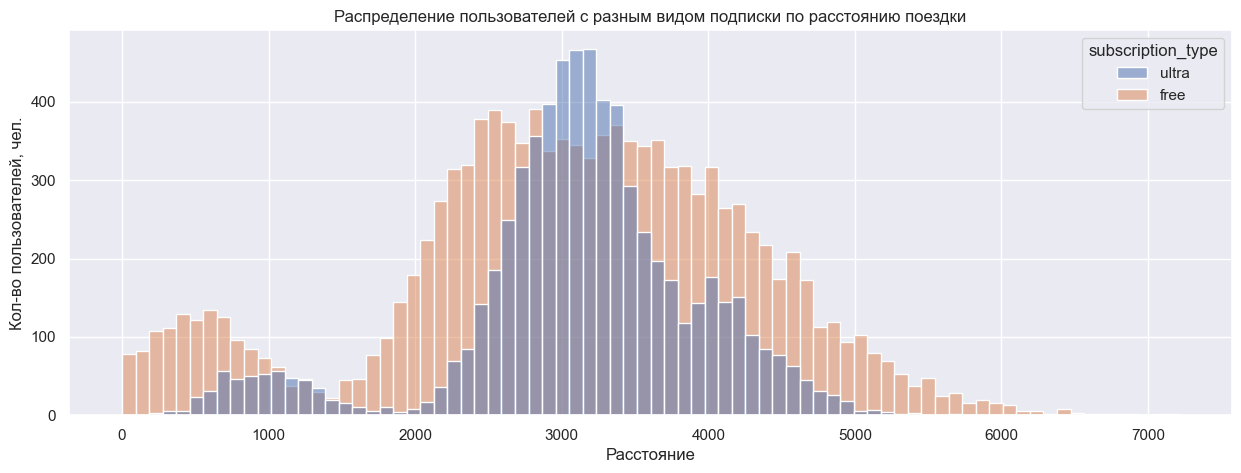

In [46]:
sns.histplot(data=df, x='distance', hue='subscription_type')
plt.title('Распределение пользователей c разным видом подписки по расстоянию поездки')
plt.xlabel('Расстояние')
plt.ylabel('Кол-во пользователей, чел.')
plt.show()

У обоих графиков(для подписки ultra и для подписки free) отображены следующие пики:
- для "ultra-графика" малый пик в районе 1000 м., большой пик в районе 3200 м, а также небольшой пик в районе 4100 м.;
- для "free-графика" малый пик в районе 500 м., большой пик в районе 2500 м.\
Между пиками графики нпохожи на нормальное распределение. При этом большой пик на "free-графике" немного "срублен".

Cоздадим доп. датафрейм с категоризированным расстоянием

In [47]:
dist_by_sub = df.pivot_table(index='distance_category', columns='subscription_type', values='user_id', aggfunc='count')
dist_by_sub

subscription_type,free,ultra
distance_category,,
0-1 км.,1130.0,267.0
1-2 км.,732.0,258.0
2-3 км.,3569.0,2067.0
3-4 км.,3653.0,3183.0
4-5 км.,2108.0,874.0
5-6 км.,477.0,23.0
свыше 6 км.,47.0,NaN


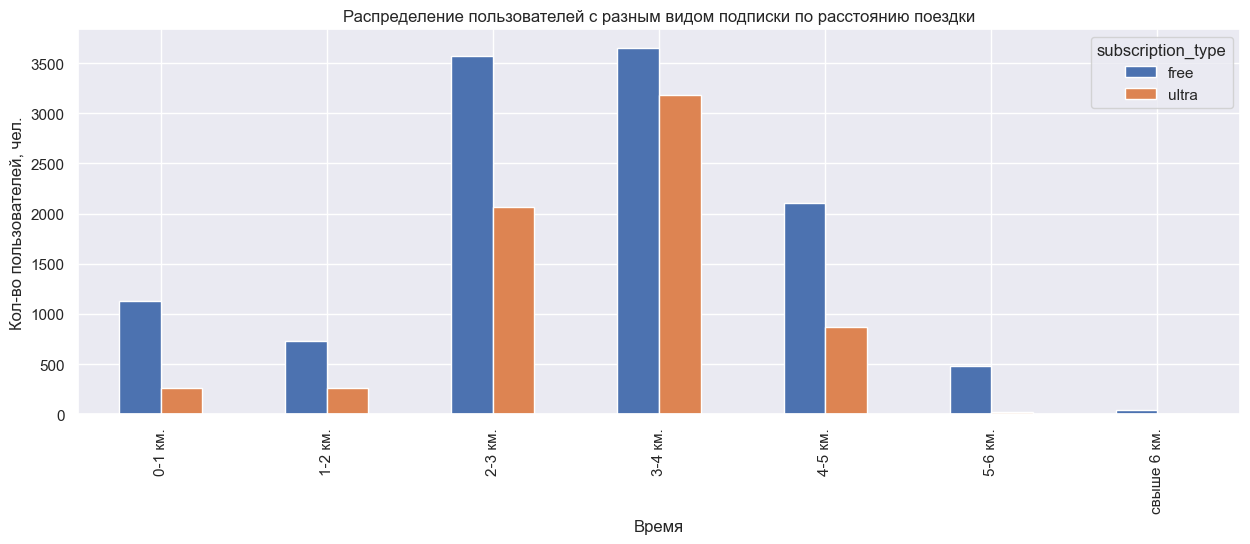

In [48]:
# построим столбчатую диаграмму для наглядности
dist_by_sub.plot(kind='bar')
plt.title('Распределение пользователей c разным видом подписки по расстоянию поездки')
plt.xlabel('Время')
plt.ylabel('Кол-во пользователей, чел.')
plt.show()

In [49]:
print(df_ultra['distance'].describe())
df_free['distance'].describe()

count    6672.000000
mean     3115.434963
std       836.686986
min       244.210438
25%      2785.359959
50%      3148.731011
75%      3559.725229
max      5699.769662
Name: distance, dtype: float64


count    11716.000000
mean      3045.357335
std       1246.269595
min          0.855683
25%       2366.991323
50%       3114.660769
75%       3903.762902
max       7211.007745
Name: distance, dtype: float64

**Вывод:**  

<span style="color:green">- количество затраченного расстояния у пользователей с разными видами подписок, в целом, пропорционально;\
    - пользователи с подпиской ultra не ездят на дистанции свыше 6 км;\
    - среди пользователей с подпиской free дистанция поездки у почти 62% составляет 2-4 км, в то же время поездка у 79% пользователей с подпиской ultra составляет 2-4 км;\
    - максимальное расстояние поездки у пользователей с подпиской ultra составляет 5.700 м., что на 1.500 м. меньше, чем максимальная дистанция поездки у пользователей с подпиской free;\
    - среднее время поездок у сравнимаемых категорий примерно равно.

Построим график распределения пользователей с разными видами подписки по времени поездки

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


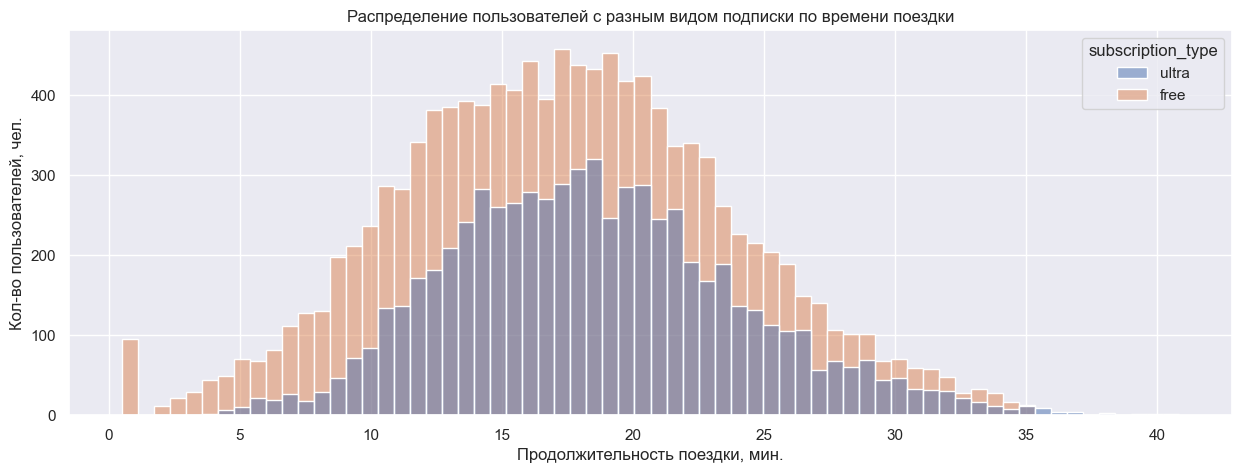

In [50]:
sns.histplot(data=df, x='duration', hue='subscription_type')
plt.title('Распределение пользователей c разным видом подписки по времени поездки')
plt.xlabel('Продолжительность поездки, мин.')
plt.ylabel('Кол-во пользователей, чел.')
plt.show()

Оба графика похожи на нормальное распределение.\
Так, среднее время поездки у обоих категорий пользователей приходится примерно на 18 минут.
При этом на "free-графике" ярко выражен пик около 1 минуты.\
Здесь может крыться следующее:
- среди пользователей с типом подписки free, вероятно, больше новичков, которые в первую минуту поездки разбираются как начать движение, и, впоследствии, столкнувшись с неудачей, отменяют поездку;
- существует техническая неполадка, связанная со стартом сессии у пользователей с подпиской free, в результате которой самокат может технически не начать движение;

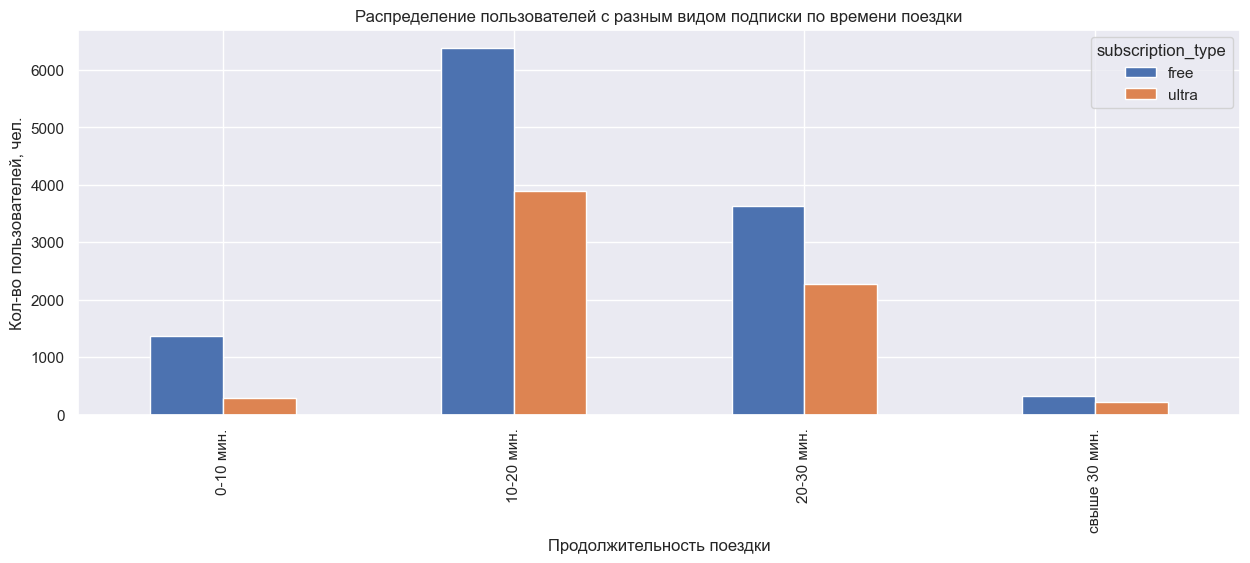

In [51]:
dur_by_sub = df.pivot_table(index='duration_category', columns='subscription_type', values='user_id', aggfunc='count')
dur_by_sub.plot(kind='bar')
plt.title('Распределение пользователей c разным видом подписки по времени поездки')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Кол-во пользователей, чел.')
plt.show()

In [52]:
dur_by_sub

subscription_type,free,ultra
duration_category,,
0-10 мин.,1376,286
10-20 мин.,6381,3901
20-30 мин.,3625,2269
свыше 30 мин.,334,216


In [53]:
print(df_ultra['duration'].describe())
df_free['duration'].describe()

count    6672.000000
mean       18.531419
std         5.572656
min         3.760353
25%        14.498947
50%        18.178153
75%        21.887063
max        40.823963
Name: duration, dtype: float64


count    11716.000000
mean        17.394835
std          6.326323
min          0.500000
25%         12.959265
50%         17.339932
75%         21.598654
max         34.948498
Name: duration, dtype: float64

**Вывод:**  

<span style="color:green">1) Основное время поездки у сравниваемых категорий составляет от 10 до 20 минут (у пользователей с подпиской free примерно в 54% случаев, с подпиской ultra - в 58% случаев.\
2) Максимальное время поездки у пользователей с подпиской free составляет примерно 35 минут, у ultra пользователей - примерно 41 минуту.\
3) Минимальное время у free пользователей составляет примерно 4 минуты, у второй категории - около полминуты.</span>

## Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из предыдущего шага и найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [54]:
# округлим время поездки "вверх" для корректности подсчёта
df['duration'] = np.ceil(df['duration'])

In [55]:
df_new = df.pivot_table(index=('user_id','ride_month'),\
                        values=('distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'),\
                        aggfunc=('sum', 'count'))
# уберём двухуровневое название столбцов
df_new.columns = [
    'rides', 'distance', 
    '2', 'duration', 
    '3', 'minute_price',
    '4', 'start_ride_price', 
    '5', 'subscription_fee'
]
# ликвидируем ненужные столбцы
df_new = df_new.drop(['2', '3', '4', '5'], axis=1)

# поскольку операции суммирования были применены ко всем столбцам, вернём к исходному виду значения в столбцах minute_price,
#start_ride_price, subscription_fee
df_new['start_ride_price'] = df_new['start_ride_price'] / df_new['rides']
df_new['minute_price'] = df_new['minute_price'] / df_new['rides']
df_new['subscription_fee'] = df_new['subscription_fee'] / df_new['rides']
df_new

rides      distance  duration  minute_price  \
user_id ride_month                                                
1       1               2   7027.511294      42.0           6.0   
        4               1    754.159807       7.0           6.0   
        8               2   6723.470560      46.0           6.0   
        10              2   5809.911100      32.0           6.0   
        11              3   7003.499363      56.0           6.0   
...                   ...           ...       ...           ...   
1534    6               2   3409.468534      26.0           8.0   
        8               2   7622.453034      48.0           8.0   
        9               1   4928.173852      23.0           8.0   
        11              4  13350.015305      78.0           8.0   
        12              1   2371.711192      16.0           8.0   

                    start_ride_price  subscription_fee  
user_id ride_month                                      
1       1                        0.0             199.0  
        4                        0.0             199.0  
        8                        0.0             199.0  
        10                       0.0             199.0  
        11                       0.0             199.0  
...                              ...               ...  
1534    6                       50.0               0.0  
        8                       50.0               0.0  
        9                       50.0               0.0  
        11                      50.0               0.0  
        12                      50.0               0.0  

[11331 rows x 6 columns]

Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [56]:
df_new['revenue'] =\
(df_new['start_ride_price'] * df_new['rides']) + (df_new['minute_price'] * df_new['duration']) + df_new['subscription_fee']

In [57]:
df_new

rides      distance  duration  minute_price  \
user_id ride_month                                                
1       1               2   7027.511294      42.0           6.0   
        4               1    754.159807       7.0           6.0   
        8               2   6723.470560      46.0           6.0   
        10              2   5809.911100      32.0           6.0   
        11              3   7003.499363      56.0           6.0   
...                   ...           ...       ...           ...   
1534    6               2   3409.468534      26.0           8.0   
        8               2   7622.453034      48.0           8.0   
        9               1   4928.173852      23.0           8.0   
        11              4  13350.015305      78.0           8.0   
        12              1   2371.711192      16.0           8.0   

                    start_ride_price  subscription_fee  revenue  
user_id ride_month                                               
1       1                        0.0             199.0    451.0  
        4                        0.0             199.0    241.0  
        8                        0.0             199.0    475.0  
        10                       0.0             199.0    391.0  
        11                       0.0             199.0    535.0  
...                              ...               ...      ...  
1534    6                       50.0               0.0    308.0  
        8                       50.0               0.0    484.0  
        9                       50.0               0.0    234.0  
        11                      50.0               0.0    824.0  
        12                      50.0               0.0    178.0  

[11331 rows x 7 columns]

## Проверка гипотез

### Установить, тратят ли пользователи с подпиской больше времени на поездки. 

Выдвинем нулевую и альтернативную гипотезы:\
Гипотеза H0: средняя длительность поездки с подписками ultra и free равна.\
Гипотеза H1: средняя длительность поездки с подпиской ultra больше, чем у пользователей с подпиской free.

In [58]:
print(df_free['duration'].describe())
print('Дисперсия выборки равна 39.94')

count    11716.000000
mean        17.394835
std          6.326323
min          0.500000
25%         12.959265
50%         17.339932
75%         21.598654
max         34.948498
Name: duration, dtype: float64
Дисперсия выборки равна 39.94


In [59]:
print(df_ultra['duration'].describe())
print('Дисперсия выборки равна 31.02')

count    6672.000000
mean       18.531419
std         5.572656
min         3.760353
25%        14.498947
50%        18.178153
75%        21.887063
max        40.823963
Name: duration, dtype: float64
Дисперсия выборки равна 31.02


 - дисперсии не сильно отличаются;
 - размер выборок не равен.\
 Нет оснований предполагать, что дисперсии существенно отличаются, однако размер выборок различный.\
 Попробуем провести стат. тест с двумя противоположными параметрами equal_var.

In [60]:
# в задаче представлены две независимые выборки, значит прибегнем к методу st.ttest_ind с предположением о неравенстве дисперсий
result = st.ttest_ind(df_ultra['duration'], df_free['duration'], alternative='greater')

print(f'p-value: {result.pvalue}')
if result.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 1.6261032773552045e-34
Отвергаем нулевую гипотезу


In [61]:
v2_result = st.ttest_ind(df_ultra['duration'], df_free['duration'], equal_var=False, alternative='greater')

print(f'p-value: {v2_result.pvalue}')
if v2_result.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 8.32088249919051e-37
Отвергаем нулевую гипотезу


Таким образом, нулевая гипотеза отвергается в обоих случаях

Странно, что стат. тест отображает наличие существенной разницы между средней продолжительностью поездок у пользователей с разной подпиской, поскольку в описании данных разница между средним временем поездки невелика.\
Отразим распределение продолжительности поездок на графике.

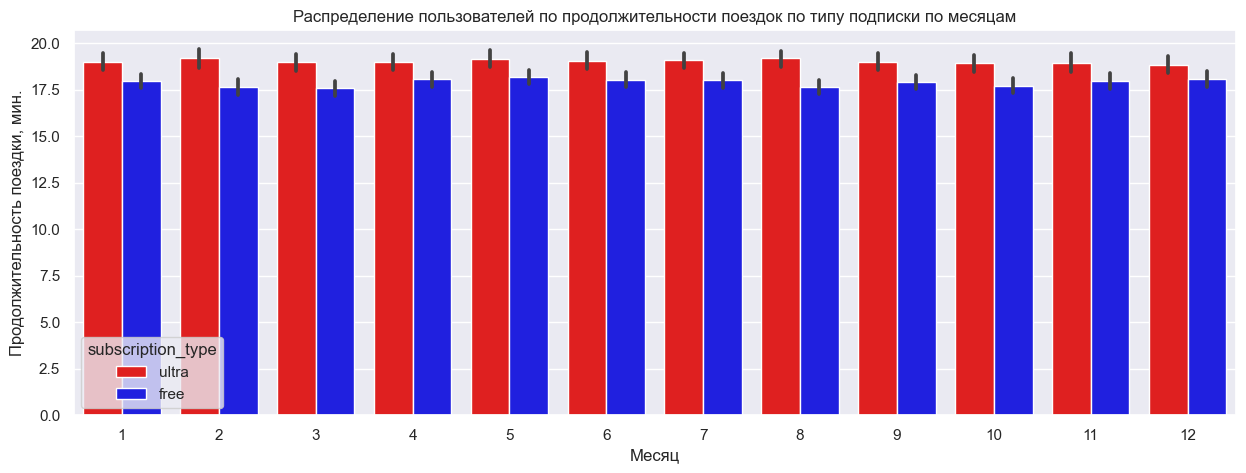

In [62]:
sns.barplot(x = 'ride_month',
            y = 'duration',
            hue = "subscription_type",
            data = df,
            palette = ['red', 'blue'])
plt.title('Распределение пользователей по продолжительности поездок по типу подписки по месяцам')
plt.ylabel('Продолжительность поездки, мин.')
plt.xlabel('Месяц')
plt.show()

На графике отчётливо видна разница между средним временем поездки у сравниваемых категорий

**Вывод**: отвергаем нулевую гипотезу о том, что средняя продолжительность поездок с разными подписками равна.\
P-значение крайне низкое, а значит, очень вероятно, что между средними продолжительностями поездок среди пользователей с разными видами подписки присутствуют существенные различия.

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Выдвинем нулевую и альтернативную гипотезы.\
H0: среднее расстояние, которое проезжают пользователи с подпиской ultra за одну поездку равно 3130 м.\
H1: среднее расстояние, которое проезжают пользователи с подпиской ultra за одну поездку больше 3130 м.

In [63]:
# речь идёт об одной выборке, значит используем метод st.ttest_1samp
result = st.ttest_1samp(df_ultra['distance'], 3130, alternative='greater')

print(f'p-value: {result.pvalue}')
if result.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 0.9224525735508029
Не удалось отвергнуть нулевую гипотезу


**Вывод:** не удалось отвергнуть нулевую гипотезу о том, что среднее расстояние поездки у пользователей с подпиской ultra не превышает 3130 м.\
Нет оснований предполагать, что среднее расстояние, проезжаемое пользователями с подпиской ultra, превышает 3130 м., значит, вероятно, нет необходимости задумываться об увеличении износостойкости самокатов.

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Выдвинем нулевую и альтернативную гипотезы.\
H0: Средняя выручка от пользователей с разными подписками равна.\
H1: Средняя выручка от пользователей с подпиской ultra выше, чем от пользователей без подписки.

In [64]:
# создадим отдельные сводные таблицы для работы с выручкой
revenue_ultra = df_new.query('subscription_fee > 0')
revenue_free = df_new.query('subscription_fee == 0')

In [65]:
revenue_ultra['subscription_fee'].value_counts()

subscription_fee
199.0    4533
Name: count, dtype: int64

In [66]:
revenue_free['subscription_fee'].value_counts()

subscription_fee
0.0    6798
Name: count, dtype: int64

In [67]:
revenue_ultra.head(10)

rides      distance  duration  minute_price  \
user_id ride_month                                                
1       1               2   7027.511294      42.0           6.0   
        4               1    754.159807       7.0           6.0   
        8               2   6723.470560      46.0           6.0   
        10              2   5809.911100      32.0           6.0   
        11              3   7003.499363      56.0           6.0   
        12              2   6751.629942      28.0           6.0   
2       3               3  10187.723006      63.0           6.0   
        4               2   6164.381824      40.0           6.0   
        6               1   3255.338202      14.0           6.0   
        7               2   6780.722964      48.0           6.0   

                    start_ride_price  subscription_fee  revenue  
user_id ride_month                                               
1       1                        0.0             199.0    451.0  
        4                        0.0             199.0    241.0  
        8                        0.0             199.0    475.0  
        10                       0.0             199.0    391.0  
        11                       0.0             199.0    535.0  
        12                       0.0             199.0    367.0  
2       3                        0.0             199.0    577.0  
        4                        0.0             199.0    439.0  
        6                        0.0             199.0    283.0  
        7                        0.0             199.0    487.0

In [68]:
revenue_free.head(10)

rides      distance  duration  minute_price  \
user_id ride_month                                                
700     1               1   2515.690719      15.0           8.0   
        2               5  13446.659764      89.0           8.0   
        3               1   3798.334905      19.0           8.0   
        4               1   2984.551206      16.0           8.0   
        6               2   5927.650988      29.0           8.0   
        7               2   4399.206279      21.0           8.0   
        8               1   4071.654669      17.0           8.0   
        10              2   6322.578618      44.0           8.0   
        11              3   8735.782625      32.0           8.0   
701     1               1   2676.472894      18.0           8.0   

                    start_ride_price  subscription_fee  revenue  
user_id ride_month                                               
700     1                       50.0               0.0    170.0  
        2                       50.0               0.0    962.0  
        3                       50.0               0.0    202.0  
        4                       50.0               0.0    178.0  
        6                       50.0               0.0    332.0  
        7                       50.0               0.0    268.0  
        8                       50.0               0.0    186.0  
        10                      50.0               0.0    452.0  
        11                      50.0               0.0    406.0  
701     1                       50.0               0.0    194.0

In [69]:
print(revenue_ultra['revenue'].describe())

count    4533.000000
mean      367.029120
std        94.163615
min       229.000000
25%       301.000000
50%       337.000000
75%       415.000000
max      1195.000000
Name: revenue, dtype: float64


In [70]:
print(revenue_free['revenue'].describe())

count    6798.000000
mean      332.894381
std       190.917413
min        58.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1952.000000
Name: revenue, dtype: float64


Поскольку разница в выручке у пользователей с разной подпиской может сильно отличаться, а выборки не равны между собой, установим параметр с неравными дисперсиями в стат. тесте

In [71]:
result_v2 = st.ttest_ind(revenue_ultra['revenue'], revenue_free['revenue'], equal_var=False, alternative='greater')

print(f'p-value: {result_v2.pvalue}')
if result_v2.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 1.5258168675601446e-36
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу. Вероятно, стоит говорить о том, что средняя выручка от пользователей с подпиской ultra выше, чем выручка от второй категории пользователей.

**Вывод:**  

<span style="color:green">1) Вероятно, средняя длительность поездок у пользователей с подпиской ultra больше, чем у пользователей с подпиской free.\
2) Нет оснований предполагать, что среднее расстояние, проезжаемое пользователями с подпиской ultra, превышает 3130 м.\
3) Предположительно средняя выручка от пользователей с подпиской ultra выше, чем выручка от второй категории пользователей.\
4) Для зависимых выборок с равным размером применяется метод scipy.stats.ttest_rel.</span>

## Распределения

### Нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %, подобрать параметры распределения, описывающего эту ситуацию, построить график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [72]:
# Предположим, что необходимое количество промокодов для рассылки n = 1000. Построим биноминальное распределение.
n = 1000
p = 0.1 # вероятность успеха
alpha = 0.05 # уровень стат. значимости

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.plot(range(0, n + 1), distr)
plt.xlim(0,300)

(0.0, 300.0)

In [73]:
# подберём необходимый параметр необходимого количества разосланных промокодов, чтобы z было меньше, чем уровень статистической
# значимости в 5%
k = 99 # количество успешных продлений подписки
N = 1161 # подбираемый параметр необходимой рассылки
p = 0.1 # вероятность продления подписки пользователем
z = 1 - st.binom.cdf(k, N, p)
z

0.9502390990500976

**Вывод:**  

<span style="color:green">Для того, чтобы как минимум 100 пользователей продлили подписку с вероятностью 95% необходимо разослать не меньше 1161 промокодов</span>

### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации необходимо построить примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [74]:
# зададим параметры биноминального распределения
n = 1000000 # количество рассылок
p = 0.4 # вероятность просмотра уведомления

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение с математическим ожиданием 400.000 
# и стандартным отклонением ~489.9
distr = st.norm(mu, sigma)

# зададим границы интервала для значения 399.500
y_1 = 399000
y_2 = 400000

# считаем вероятность получить значение от y1 до y2
output = distr.cdf(399500)

print(f'Вероятность того, что уведомление откроют менее 399 500 пользователей равна {(output*100).round(2)}%')

Вероятность того, что уведомление откроют менее 399 500 пользователей равна 15.37%


## ОБЩИЙ ВЫВОД:
<span style="color:green">**1)** В ходе предобработки данных установлено, что пропуски и дубликаты отсутствуют.\
    **2)** В процессе исследовательского анализа данных установлено, что аномальные и необъяснимые значения отсутствуют. Вузуализирована общая информация о пользователях и поездках и сделаны следующие выводы:\
    - Услугами сервиса аренды самокатов пользуются люди от 12 до 43 лет;\
    - Максимальное количество пользователей в возрасте 25 лет, этот же возраст является медианным;\
    - Большая часть всех пользователей используют подписку "free". Всего их 835, что составляет около 54% от общего количества и на 136 больше, чем с подпиской "ultra";\
    - Максимальное количество в 219 поездок совершено в Пятигорске. Минимальное количество в 168 поездок совершено в Москве;\
    - За одну поездку пользователи преодолевают расстояние от 1 до 7211 метров. Медиана пройденной дистанции равна 3134 метров. Наблюдаются два пика. Малый пик около 700 метров, большой пик около 3200 метров. Между пиками значения нормально распределены;\
    - Продолжительность поездок нормально распределена от 0 до 41 минуты. Продолжительность в 18 минут является наиболее распространенной, а также медианой. Наблюдается выброс размером около 100 поездок с продолжительностью в 1 минуту.\
    **3)** В процессе объединения таблиц и создания новых датафреймов провизуализирована информация о продолжительности и продолжительности поездок у пользователей с разной подпиской и сделаны следующие выводы:\
    - количество затраченного расстояния у пользователей с разными видами подписок, в целом, пропорционально;\
    - пользователи с подпиской ultra не ездят на дистанции свыше 6 км;\
    - среди пользователей с подпиской free дистанция поездки у почти 62% составляет 2-4 км, в то же время поездка у 79% пользователей с подпиской ultra составляет 2-4 км;\
    - максимальное расстояние поездки у пользователей с подпиской ultra составляет 5.700 м., что на 1.500 м. меньше, чем максимальная дистанция поездки у пользователей с подпиской free;\
    - среднее время поездок у сравнимаемых категорий примерно равно.\
    **4)** Создан датафрейм с агрегированными данными о поездках и рассчитана суммарная выручка от каждого пользователя за каждый месяц.\
    **5)** Проверены гипотезы, в результате чего выявлено, что:\
    - вероятно, средняя длительность поездок у пользователей с подпиской ultra больше, чем у пользователей с подпиской free;\
    - нет оснований предполагать, что среднее расстояние, проезжаемое пользователями с подпиской ultra, превышает 3130 м;\
    - предположительно средняя выручка от пользователей с подпиской ultra выше, чем выручка от второй категории пользователей;\
    - для зависимых выборок с равным размером применяется метод scipy.stats.ttest_rel.\
    **6) Анализ показал, что:\
    - стоит проверить, существуют ли неполадки, связанные со стартом поездки;\
    - тип подписки влияет на проезжаемое пользователями с разной подпиской расстояние, соответственно, компании выгодно увеличивать кол-во пользователей с подпиской ultra;\
    - средняя выручка от пользователей с подпиской ultra выше, чем от тех, у кого подписка free, следовательно, для роста бизнеса стоит подумать об увеличении пользователей с подпиской ultra.**